In [148]:
import numpy as np
from scipy.spatial import Voronoi, KDTree
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_ellipses_exp2Q(
    r, Qxx, Qxy, L=None, idx=None,
    draw_director=True, color_by_s=False, ax=None, lw=1.0, alpha=1.0,
s_min = None, s_max=None, x_min = None, x_max =None, y_min = None, y_max=None):
    """
    Plot ellipses for Σ = exp(2Q) with Q = [[Qxx,Qxy],[Qxy,-Qxx]] (unit determinant).
    The ellipse is the contour x^T Σ^{-1} x = 1, i.e. semi-axes a=e^{+s}, b=e^{-s},
    orientation θ = 0.5*atan2(Qxy, Qxx), with s = sqrt(Qxx^2 + Qxy^2).

    Args:
      r  : (N,2) centers
      Qxx,Qxy : (N,) arrays
      L  : box size (optional; sets x/y limits to [0,L])
      idx: indices to plot (optional subsample). If None, plots all.
      draw_director: draw a small line along director angle
      color_by_s: color ellipses by s magnitude
      ax : matplotlib Axes (optional)
      lw, alpha : line width and alpha for ellipses
    """
    r = np.asarray(r)
    Qxx = np.asarray(Qxx)
    Qxy = np.asarray(Qxy)
    N = len(Qxx)
    if idx is None:
        idx = np.arange(N)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    # spectral data
    s = np.sqrt(Qxx*Qxx + Qxy*Qxy)
    theta = 0.5 * np.arctan2(Qxy, Qxx)        # radians
    a = np.exp(+s)                             # semi-major
    b = np.exp(-s)                             # semi-minor
    ang_deg = np.degrees(theta)

    if color_by_s:
        # normalize s for colormap
        sm = plt.cm.ScalarMappable(cmap='viridis')
        s_plot = s[idx]
        if(s_min is None or s_max is  None):
            cmin, cmax = (s_plot.min(), s_plot.max()) if s_plot.size else (0,1)
            sm.set_clim(cmin, cmax)
        else:
            sm.set_clim(s_min, s_max)
        colors = sm.to_rgba(s[idx])
    else:
        colors = None

    for k_i, k in enumerate(idx):
        e = Ellipse(
            xy=(r[k,0], r[k,1]),
            width=2*a[k]/np.sqrt(np.pi), height=2*b[k]/np.sqrt(np.pi),
            angle=ang_deg[k], fill=False,
            linewidth=lw,
            alpha=alpha,
            edgecolor=(colors[k_i] if color_by_s else 'k')
        )
        ax.add_patch(e)

    if draw_director and len(idx) > 0:
        seg_len = 0.6
        ux = np.cos(theta[idx]); uy = np.sin(theta[idx])
        ax.quiver(r[idx,0], r[idx,1], ux, uy,
                  angles='xy', scale_units='xy', scale=1/seg_len,
                  width=0.003, headwidth=0, color='k', alpha=alpha)

    if L is not None:
        ax.set_xlim(0, L); ax.set_ylim(0, L)
    elif x_min is not None and x_max is not None and y_min is not None and y_max is not None:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        # a little padding
        mins = r[idx].min(axis=0); maxs = r[idx].max(axis=0)
        pad = 0.05*(maxs - mins + 1e-9)
        ax.set_xlim(mins[0]-pad[0], maxs[0]+pad[0])
        ax.set_ylim(mins[1]-pad[1], maxs[1]+pad[1])

    ax.set_aspect('equal', adjustable='box')
    ax.set_title("Unit-determinant ellipses  Σ = exp(2Q)")
    if color_by_s:
        plt.colorbar(sm, ax=ax, label='s = √(Qxx²+Qxy²)')
    return ax
import xarray
import zarr

In [56]:
res = zarr.open_array("https://public.czbiohub.org/royerlab/zebrahub/imaging/single-objective/ZSNS001.ome.zarr/0/")
res = zarr.open_array("https://public.czbiohub.org/royerlab/zebrahub/imaging/multi-view/ZMNS001.ome.zarr/0/")

In [57]:
resolution = np.array([1.24, 0.439, 0.439])
resolution = np.array([1.97, 0.485, 0.485])

In [58]:
from skimage.transform import resize, rescale

In [59]:
timestep = -1
img = res[timestep, 0, :, :, :]

In [60]:
rescaled_img = rescale(img, scale=resolution/resolution.max(), order=1, preserve_range=True, anti_aliasing=True)

In [61]:
import napari

In [62]:
viewer = napari.Viewer()
viewer.add_image(rescaled_img, name='rescaled_img')

<Image layer 'rescaled_img' at 0x326c1f4d0>

In [13]:
from skimage.measure import marching_cubes

In [17]:
verts, faces, _, _ = marching_cubes(rescaled_img)

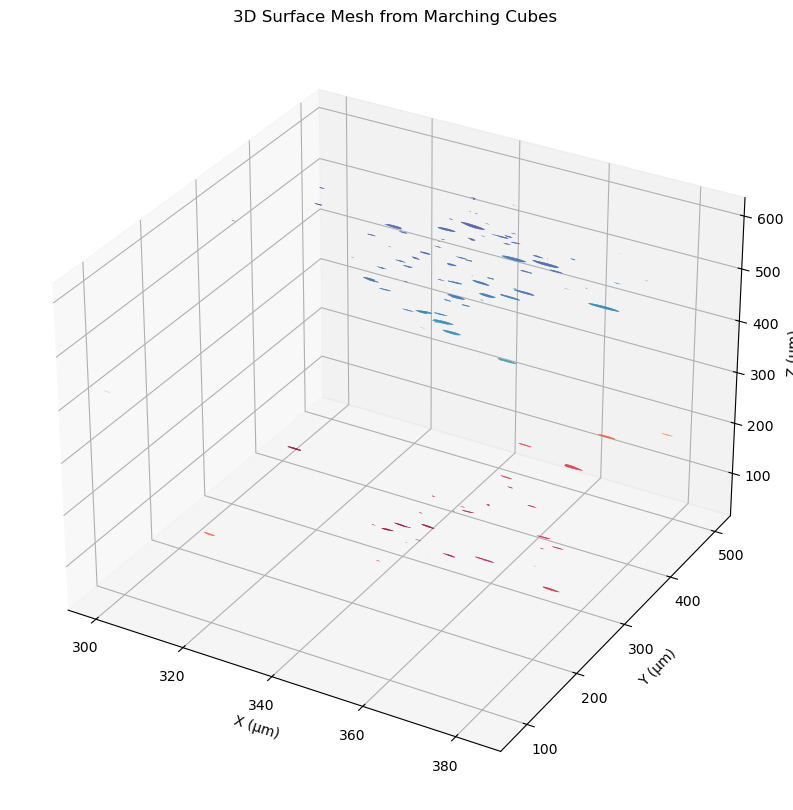

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.set_zlabel("Z (µm)")
ax.set_title("3D Surface Mesh from Marching Cubes")
plt.show()

In [ ]:
from scipy.linalg import svd, cholesky
X_cov = np.load("cov.npz")['arr_0']
X_cov = (X_cov + X_cov.T)/2  # ensure symmetry
vals, vecs = np.linalg.eigh(X_cov)
tolerance = 1e-10
vals = np.maximum(vals, tolerance)
X_cov = (vecs * vals) @ vecs.T
#U, s, Vh = svd(X_cov)
#s[s < 1e-10] = 0.0
#X_cov = (U * s) @ Vh
X_cov_inv =np.linalg.inv(X_cov)
X_cov_inv = (X_cov_inv + X_cov_inv.T)/2  # ensure symmetry
vals_inv = np.linalg.eigvalsh(X_cov_inv)

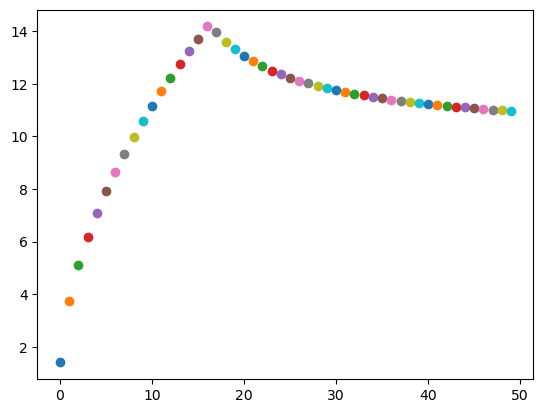

In [245]:
alpha0 =  vals_inv.max()
for alpha_idx,alpha in enumerate(np.linspace(0.01*alpha0, 3*alpha0)):
    rescaled_inv = X_cov_inv/alpha
    M = np.eye(X_cov.shape[0]) - rescaled_inv
    U_M, s_M, Vh_M = svd(M)
    W = np.diag(np.sqrt(s_M)) @ Vh_M
    plt.scatter(alpha_idx, 1/W.std())

In [203]:
def init_particles_in_circle(R=1.0, a=0.1):
    """
    Initialize particles on a square grid of spacing a,
    keep one per square, only inside a circle of radius R.
    Center of circle at (0,0).
    """
    # Grid of cell centers
    xs = np.arange(-R + 0.5*a, R, a)
    ys = np.arange(-R + 0.5*a, R, a)
    X, Y = np.meshgrid(xs, ys, indexing='xy')

    # Mask: keep only centers inside circle
    mask = X**2 + Y**2 <= R**2

    # Stack into (N, 2) array
    r = np.column_stack((X[mask], Y[mask]))
    return r

In [215]:
np.random.seed(42)
N = 2048
R0 = 50
kappa = 2.0
gamma_b = 1.0
u0, v0 = np.random.rand(N), np.random.rand(N)
r = np.zeros((N, 2))
r[:,0] = R0*np.sqrt(u0)*np.cos(2*np.pi*v0)
r[:,1] = R0*np.sqrt(u0)*np.sin(2*np.pi*v0)
r = init_particles_in_circle(R=R0, a=1.0)
r = r[np.random.choice(len(r), size=N, replace=False)]
Qxx = np.zeros(N)
Qxy = np.zeros(N)
dt = 1e-4
steps = 180000
steps_voronoi = 10
k_wall = 10.0
r_wall = R0*1.1
diffusion = 0.1
save_period = 10000

In [216]:
history_r = []
history_Qxx = []
history_Qxy = []
for step in range(steps):
    if(step % steps_voronoi == 0):
        j = KDTree(r).query(r, k=11)[1][:,1:]
        i = np.repeat(np.arange(N), j.shape[1])
        j = j.flatten()
        #mask = i != j
        #i = i[mask]
        #j = j[mask]
    if(step % save_period == 0):
        print(f"Step {step}/{steps}")
        history_r.append(r.copy())
        history_Qxx.append(Qxx.copy())
        history_Qxy.append(Qxy.copy())
    energy_grads_Qxx = kappa*4*Qxx
    energy_grads_Qxy = kappa*4*Qxy
    
    r_mod = np.linalg.norm(r, axis=1)
    wall_forces = k_wall * (r_wall - r_mod)[:, np.newaxis] * (r / r_mod[:, np.newaxis])
    wall_forces[r_mod < r_wall] = 0.0

    r_ij = r[i] - r[j]
    r2_ij = np.sum(r_ij**2, axis=1)
    coords_2diffs = r_ij[:,0]**2 - r_ij[:,1]**2
    Q_xx_i = Qxx[i]
    Q_xy_i = Qxy[i]
    Q_xx_j = Qxx[j]
    Q_xy_j = Qxy[j]
    scalar_Q_ij = Q_xx_i*Q_xx_j + Q_xy_i*Q_xy_j
    sum_Q_xx = Q_xx_i + Q_xx_j
    sum_Q_xy = Q_xy_i + Q_xy_j

    diff_Q_xx = Q_xx_i - Q_xx_j
    diff_Q_xy = Q_xy_i - Q_xy_j

    



    F = 0.25*(1+2*(scalar_Q_ij))*r2_ij -0.25*sum_Q_xx*coords_2diffs - 0.5*sum_Q_xy*r_ij[:,0]*r_ij[:,1]  #+ (0.5)*(diff_Q_xx**2 + diff_Q_xy**2)
    potential_strength = np.exp(-F)*(dt*gamma_b)

    forces_x =  potential_strength*( 0.5*((1+2*(scalar_Q_ij)) - sum_Q_xx)*r_ij[:,0] - 0.5*sum_Q_xy*r_ij[:,1] )
    forces_y =  potential_strength*( 0.5*((1+2*(scalar_Q_ij)) + sum_Q_xx)*r_ij[:,1] - 0.5*sum_Q_xy*r_ij[:,0] )
    forces_Qxx_i = potential_strength*(-0.25*coords_2diffs + 0.5*Q_xx_j*r2_ij)  #+ diff_Q_xx)
    forces_Qxx_j = potential_strength*(-0.25*coords_2diffs + 0.5*Q_xx_i*r2_ij)  #- diff_Q_xx)
    forces_Qxy_i = potential_strength*(-0.5*r_ij[:,0]*r_ij[:,1] + 0.5*Q_xy_j*r2_ij)  #+ diff_Q_xy) 
    forces_Qxy_j = potential_strength*(-0.5*r_ij[:,0]*r_ij[:,1] + 0.5*Q_xy_i*r2_ij) #- diff_Q_xy)

    np.add.at(r[:,0], i, forces_x)
    np.add.at(r[:,1], i, forces_y)
    np.subtract.at(r[:,0], j, forces_x)
    np.subtract.at(r[:,1], j, forces_y)
    np.add.at(Qxx, i, forces_Qxx_i)
    np.add.at(Qxx, j, forces_Qxx_j)
    np.add.at(Qxy, i, forces_Qxy_i)
    np.add.at(Qxy, j, forces_Qxy_j)
    Qxx -= dt*energy_grads_Qxx
    Qxy -= dt*energy_grads_Qxy
    r += dt*wall_forces
    #dtheta = np.random.normal(size=N, scale=np.sqrt(2*diffusion*dt))
    #cos_2dtheta = np.cos(dtheta)
    #sin_2dtheta = np.sin(dtheta)
    #new_Qxx = Qxx * cos_2dtheta + Qxy * sin_2dtheta
    #new_Qxy = -Qxx * sin_2dtheta + Qxy * cos_2dtheta
    #Qxx = new_Qxx
    #Qxy = new_Qxy
    #r += np.random.normal(size=(N, 2), scale=np.sqrt(2*diffusion*dt))

history_r = np.array(history_r)
history_Qxx = np.array(history_Qxx)
history_Qxy = np.array(history_Qxy)

Step 0/180000
Step 10000/180000
Step 20000/180000
Step 30000/180000
Step 40000/180000
Step 50000/180000
Step 60000/180000
Step 70000/180000
Step 80000/180000
Step 90000/180000
Step 100000/180000
Step 110000/180000
Step 120000/180000
Step 130000/180000
Step 140000/180000
Step 150000/180000
Step 160000/180000
Step 170000/180000


In [217]:
a = 1+2*scalar_Q_ij-sum_Q_xx
b = 1+2*scalar_Q_ij+sum_Q_xx
c = sum_Q_xy
traces = a + b
dets = a*b - c*c
lambda_1 = 0.5*(traces + np.sqrt(traces**2 - 4*dets))
lambda_2 = 0.5*(traces - np.sqrt(traces**2 - 4*dets))

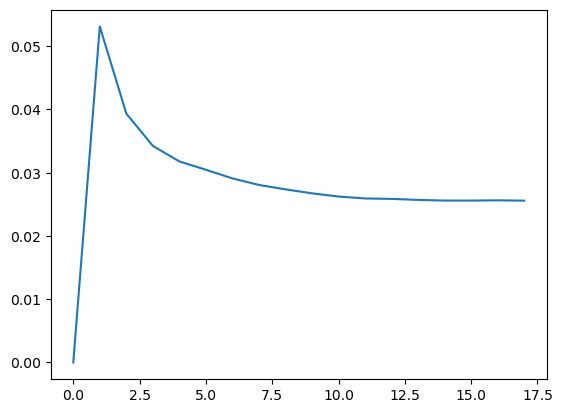

In [218]:
s_avg = np.sqrt(history_Qxx**2 + history_Qxy**2).mean(axis=1)
plt.plot(np.arange(len(s_avg))*save_period*dt, s_avg)

In [219]:
#from scipy.stats import binned_statistic_2d
#statistic, x_edges, y_edges,_ = binned_statistic_2d(r[:,0], r[:,1], np.sqrt(Qxx**2 + Qxy**2), bins=20)
#plt.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, statistic.T, levels=100)
#plt.show()

In [220]:
for i in range(len(history_r)):
    fig, ax = plt.subplots(figsize=(6,6))
    plot_ellipses_exp2Q(history_r[i], history_Qxx[i], history_Qxy[i], draw_director=False, color_by_s=True, ax=ax, s_min=0, s_max=np.sqrt((history_Qxx**2 + history_Qxy**2).max()))
    ax.set_title(f"Step {i*save_period}")
    plt.savefig(f"videos/ellipse_step_{i*save_period:06d}.png", dpi=150)
    plt.close(fig)

In [ ]:
def polar_bin_average(x, y, v,
                      nbins_r=50,
                      nbins_theta=36,
                      rmin=0.0,
                      rmax=None,
                      theta_range=(0.0, 2*np.pi)):
    """
    Bin a scalar quantity v(x,y) in polar (r, theta) bins and compute the average in each bin.

    Parameters
    ----------
    x, y : 1D arrays
        Cartesian coordinates of samples (same shape as v).
    v : 1D array
        Values to average in each polar bin.
    nbins_r : int
        Number of radial bins.
    nbins_theta : int
        Number of angular bins.
    rmin, rmax : float
        Radial range. If rmax is None, it is set to max(r).
    theta_range : (float, float)
        Angular range (start, stop), typically (0, 2π) or (-π, π).

    Returns
    -------
    r_centers : 1D array, shape (nbins_r,)
        Radial bin centers.
    theta_centers : 1D array, shape (nbins_theta,)
        Angular bin centers.
    v_avg : 2D array, shape (nbins_r, nbins_theta)
        Average v in each (r, theta) bin.
        v_avg[i, j] corresponds to r_centers[i], theta_centers[j].
        Empty bins are filled with np.nan.
    counts : 2D array, shape (nbins_r, nbins_theta)
        Number of samples in each bin.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    v = np.asarray(v)

    # polar coords
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)  # in (-π, π]
    
    # map theta to desired range
    theta_min, theta_max = theta_range
    if (theta_min, theta_max) == (0.0, 2*np.pi):
        theta = np.mod(theta, 2*np.pi)  # [0, 2π)
    else:
        # simple shift if you use e.g. (-π, π)
        # you can adapt this if you want arbitrary ranges
        width = theta_max - theta_min
        theta = theta_min + np.mod(theta - theta_min, width)

    if rmax is None:
        rmax = r.max()

    # bin edges
    r_edges = np.linspace(rmin, rmax, nbins_r + 1)
    theta_edges = np.linspace(theta_min, theta_max, nbins_theta + 1)

    # sum of v in each bin
    sums, _, _ = np.histogram2d(r, theta,
                                bins=(r_edges, theta_edges),
                                weights=v)

    # counts in each bin
    counts, _, _ = np.histogram2d(r, theta,
                                  bins=(r_edges, theta_edges))

    # avoid division by zero
    with np.errstate(invalid="ignore", divide="ignore"):
        v_avg = sums / counts
    v_avg[counts == 0] = np.nan  # mark empty bins

    # bin centers
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])

    return r_centers, theta_centers, v_avg, counts


In [ ]:
history_s = np.sqrt(history_Qxx**2+history_Qxy**2)
history_angle = np.arctan(history_Qxy, history_Qxx)/2

In [ ]:
plt.scatter(history_r[-1,:,0], history_r[-1,:,1], c=history_s[-1])
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(history_r[-1,:,0], history_r[-1,:,1], c=history_angle[-1], vmin=-np.pi/8, vmax=np.pi/8, cmap='seismic')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()